[アルゴリズムパズル ―プログラマのための数学パズル入門](https://www.amazon.co.jp/dp/4873116694)を読んでいて、[問題解決力を鍛える!アルゴリズムとデータ構造](https://www.amazon.co.jp/dp/4065128447)で勉強していることを試してみるのにちょうどいい問題があったので、実装してみた。

#### 問題20
>正の整数が三角形状に配置されている。この三角形の頂点から初めて、それぞれの回想で直前に選んだ数字と隣接する１つの数字を選びながらふもとまで降下していくときに、たどった数字を合計したあたいの最大値を求めるアルゴリズムを設計せよ（もちろん、全探索よりも効率的であること）。

なお、ブログの記事は[こちら](https://aratamotsu.hatenadiary.com/entry/2020/12/25/174902)。

In [1]:
import random
import time
from collections import deque
import math
import pandas as pd
from heapq import heappop, heappush

## ちょっとした関数とグラフの作成 

In [2]:
# i段目の左からj番目のnodeの全体での順序を返す関数
def to_index(i, j):
    return int(i * (i + 1) / 2 + j)

# n番目のノードが上から何番目の階層にいるのかを返す関数。
def to_layer(N):
    return math.floor((-1 + math.sqrt(1 + 8 * N)) / 2 ) 

def my_graph(N):
    G = []
    for i in range(N):
        for j in range(i+1):
            if i < N -1:
                # i段目の左からj番目のnodeはi+1段目のj番目とj+1番目のnodeへのedgeを持つ
                G.append([to_index(i+1, j), to_index(i+1, j+1)])
            else:
                # 最後の段にあるnodeは、行き先となるedgesを持たない
                G.append([]) 
                
    # nodeの総数
    total_node = to_index(N-1, N-1)

    # 各nodeで得られるスコアを設定
    #node_score = [random.choice([0, 10]) for i in range(total_node + 1)]
    node_score = [random.randint(1, 10)  for i in range(total_node + 1)]

    return G, node_score

## 全探索の実装

In [3]:
# 全探索を全探索で実装してみる。
def all_search(G, N):
    start = time.time()
    result = -1
    for i in range(2**(N-1)):
        # ビット列に従い、左右をたどっていく
        current_node = 0 # 最初のnode
        score = node_score[current_node] # 最初のnodeのscoreを足しておく
        
        for j in range(N-1):
            current_node = G[current_node][(i >> j) & 1] # 次のnodeへ移動
            score = score + node_score[current_node] # 移動したらscoreを足す
        
        result = max(result, score) # 最終的なscoreがこれまでのものより大きければ更新する

    return result, time.time() - start

## 動的計画法の実装

In [4]:
def DP(G, method = "DFS"):
    start = time.time()

    # 各nodeの結果を記録する
    node_result = {i : -1 for i in range(len(G))}

    # stackに最初のnodeを追加
    stack = deque([0])
    node_result[0] = node_score[0]

    result = 0

    while(stack):
        if method == "DFS":
            c_node = stack.pop()
        else:
            c_node = stack.popleft()
        for n_node in G[c_node]:
            if node_result[c_node] + node_score[n_node] > node_result[n_node]:
                # node_result[n_node] = max(node_result[n_node], node_result[c_node] + node_score[n_node]) 
                node_result[n_node] = node_result[c_node] + node_score[n_node]
                stack.append(n_node)
                result = max(result, node_result[n_node])

    return result, time.time() - start

## 動的計画法に加えて枝刈りを入れる

In [5]:
def DP_cut(G, method = "DFS"):
    start = time.time()

    # 各nodeの結果を記録する
    node_result = {i : -1 for i in range(len(G))}

    # stackに最初のnodeを追加
    stack = deque([0])
    node_result[0] = node_score[0]

    result = 0
    cut = 0
    
    while(stack):
        if method == "DFS":
            c_node = stack.pop()
        else:
            c_node = stack.popleft()

        for n_node in G[c_node]:
            if node_result[c_node] + node_score[n_node] > node_result[n_node]:
                node_result[n_node] = node_result[c_node] + node_score[n_node]
                if (node_result[n_node] + (N - 1 - to_layer(n_node)) * 10) > result:
                    stack.append(n_node)
                    result = max(result, node_result[n_node])
                else:
                    cut = cut + 1
    
    #print(cut)
    return result, time.time() - start

## ダイクストラ

In [6]:
def Dijkstra(G):
    start = time.time()

    # 各nodeの結果を記録する
    node_result = {i : -1 for i in range(len(G))}

    # heapに最初のnodeを追加
    hp = []
    node_result[0] = node_score[0]
    heappush(hp, (-node_result[0], 0))
    
    result = 0
    while(hp):
        # ヒープからノードを取り出し、
        c_node = heappop(hp)[1]
        
        for n_node in G[c_node]:
            # 取り出したノードが向かう先のノードについて、緩和を行う
            if node_result[c_node] + node_score[n_node] > node_result[n_node]:
                node_result[n_node] = node_result[c_node] + node_score[n_node]
                result = max(result, node_result[n_node])
                heappush(hp, (-node_result[n_node], n_node))

    return result, time.time() - start

## ダイクストラに枝刈りを加える

In [7]:
def Dijkstra_cut(G):
    start = time.time()

    # 各nodeの結果を記録する
    node_result = {i : -1 for i in range(len(G))}

    # heapに最初のnodeを追加
    hp = []
    node_result[0] = node_score[0]
    heappush(hp, (-node_result[0], 0))
    
    result = 0
    cut = 0 # 枝狩りの回数カウント用
    while(hp):
        # ヒープからノードを取り出し、
        c_node = heappop(hp)[1]
        
        for n_node in G[c_node]:
            if node_result[c_node] + node_score[n_node] > node_result[n_node]:
                # 取り出したノードが向かう先のノードについて、緩和を行う
                node_result[n_node] = node_result[c_node] + node_score[n_node]
                
                # 枝狩りできるかどうか確認して、枝狩できなければ、ヒープに入れる
                if (node_result[n_node] + (N - 1 - to_layer(n_node)) * 10) > result:
                    result = max(result, node_result[n_node])
                    heappush(hp, (-node_result[n_node], n_node))
                else:
                    cut = cut + 1
    #print(cut)
    return result, time.time() - start

## 貪欲法も実装してみる
問題設定からは明らかだけど、最適解は貪欲法では求められない。

In [8]:
def Greeding(G):
# nodeの総数
    start = time.time()

    # stackに最初のnodeを追加
    stack = deque([0])
    score = 0

    while(stack):
        c_node = stack.pop()
        score = score + node_score[c_node]
        
        connected_node = G[c_node]
        if connected_node:
            # まどろっこしいが、一般の有向グラフに適用できるように書いておく
            next_scores = [node_score[x] for x in connected_node]
            max_score = max(next_scores)
            n_node = G[c_node][next_scores.index(max_score)]
            stack.append(n_node)
        
    result = score
    return result, time.time() - start

## 実行速度を計測してみる
全探索は遅くて邪魔なので、コメントアウトしている。

In [9]:
# 階層数
stairs = 50

# それぞれの階層数で、何個のグラフを試してみるか、その個数
roup = 100

elapsed_time = {}

#algorithms = ["all_search", "DP_DFS", "DP_BFS", "DP_DFS_cut", "DP_BFS_cut", "Dijkstra", "Dijkstra_cut"]
algorithms = ["DP_DFS", "DP_BFS", "DP_DFS_cut", "DP_BFS_cut", "Dijkstra", "Dijkstra_cut"]

for algorithm in algorithms:
    elapsed_time[algorithm] = []

for N in range(1, stairs):
    #s_all_search = 0
    s_DP_DFS = 0
    s_DP_BFS = 0
    s_DP_DFS_cut = 0
    s_DP_BFS_cut = 0
    s_Dijkstra = 0
    s_Dijkstra_cut = 0
    
    start = time.time()
    for _ in range(roup):
        G, node_score = my_graph(N)
        
        # 所要時間を足していく
        #s_all_search = s_all_search + all_search(G, N)[1]
        s_DP_DFS = s_DP_DFS + DP(G)[1]
        s_DP_BFS = s_DP_BFS + DP(G, method="BFS")[1]
        s_DP_DFS_cut = s_DP_DFS_cut + DP_cut(G)[1]
        s_DP_BFS_cut = s_DP_BFS_cut + DP_cut(G, method="BFS")[1]
        s_Dijkstra = s_Dijkstra + Dijkstra(G)[1]
        s_Dijkstra_cut = s_Dijkstra_cut + Dijkstra_cut(G)[1]

    
    # 平均処理時間を算出し、log10を取る
    #elapsed_time["all_search"].append(s_all_search / roup)
    elapsed_time["DP_DFS"].append(s_DP_DFS / roup)
    elapsed_time["DP_BFS"].append(s_DP_BFS / roup)
    elapsed_time["DP_DFS_cut"].append(s_DP_DFS_cut / roup)
    elapsed_time["DP_BFS_cut"].append(s_DP_BFS_cut / roup)
    elapsed_time["Dijkstra"].append(s_Dijkstra / roup)
    elapsed_time["Dijkstra_cut"].append(s_Dijkstra_cut / roup)

    # print(N, time.time() - start)

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

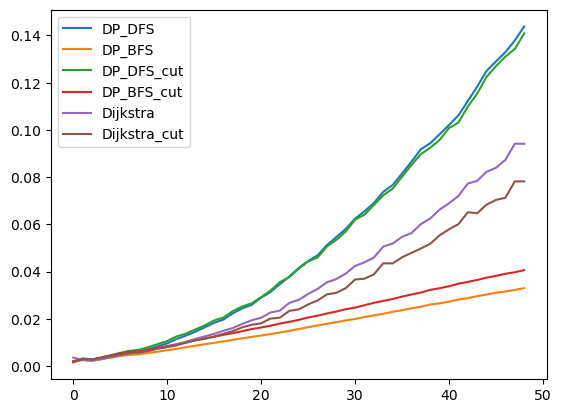

In [10]:
# 計算時間の表示
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(elapsed_time)

plt.figure()
plt.style.use(['default']) 

df.applymap(math.sqrt).plot()
#plt.savefig('./plot.png', dpi=300)
#plt.close('all')

## メモ：ヒープ（優先度付きキュー）の復習

In [4]:
from heapq import heappop, heappush
hp = []
heappush(hp, (1, 5))
heappush(hp, (2, 4))
heappush(hp, (3, 3))
heappush(hp, (4, 2))
heappush(hp, (5, 1))

In [11]:
if hp:
    y = heappop(hp)
    print(y)
else:
    print("hp is empty")

hp is empty
